## Exploratory Data Analysis and Pre-Model Cleaning

In this notebook, we analyze the data containing call and put prices from Apple (AAPL). We will take a look at the basic features we are working with, as well clean the data to prepare it for modeling using ML methods. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
aapl_df = pd.read_pickle('/home/jul-ian/Github/ml-options/data/processed/stocks_df/aapl_df.pkl')

print(aapl_df.columns)
aapl_df.head()

Index(['date_priced', 'date_expired', 'days_to_maturity', 'stock_bid',
       'stock_ask', 'option_bid', 'option_ask', 'strike_price', 'option_type',
       'rf_rate'],
      dtype='object')


,date_priced,date_expired,days_to_maturity,stock_bid,stock_ask,option_bid,option_ask,strike_price,option_type,rf_rate
0,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.01,130.0,put,0.017294
1,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.01,135.0,put,0.017294
2,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.01,140.0,put,0.017294
3,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.05,142.0,put,0.017294
4,2018-05-22,2018-05-24,2,187.3,187.32,0.0,0.07,143.0,put,0.017294


The Black-Scholes formula for the price of a call (C = N(d_1)S_t - N(d_2)Ke^(-rt)) includes the price of the stock at time t. But in the real world, there are separate prices at which buyers are willing to buy, and sellers are willing to sell. The maximum at which a buyer will buy is the bid price, while the lowest the seller will sell is the ask price. The ask price is usually higher than the bid, and the difference is referred to as the bid-ask spread. As an initial simplification, we will take the midpoint of the bid and ask to be the input price. We will also do this for the price of the option, since it also has bid and ask prices.

In [3]:
aapl_df['stock_mid'] = (aapl_df['stock_bid'] + aapl_df['stock_ask']) / 2
aapl_df['option_mid'] = (aapl_df['option_bid'] + aapl_df['option_ask']) / 2

We see that the 'option_type' column denotes whether the option is as call or put. At this initial stage, for simplicity, we will focus on just calls.

In [4]:
display(aapl_df['option_type'].value_counts().sort_index())

aapl_call_df = aapl_df[aapl_df['option_type'] == 'call']

aapl_call_df.shape

call    492384
put     483595
Name: option_type, dtype: int64

(492384, 12)

We will examine the various stock rices first. Looking at the distributions of each, the minimum prices seem concerning. It would be rare that the price of a stock would reach 0 dollars, unless it went bankrupt. Since it is the stock price of Apple, it can be verified that the price has never reached 0 dollars, especially in the time interval this data was pulled. The clustering also makes it evident that this is exceptionally deviant from the rest of the prices.

count    975979.000000
mean        224.037486
std          96.137452
min           0.000000
25%         136.960000
50%         204.530000
75%         284.390000
max         506.150000
Name: stock_bid, dtype: float64

count    975979.000000
mean        224.157530
std          96.186034
min           0.000000
25%         137.000000
50%         204.800000
75%         284.490000
max         506.180000
Name: stock_ask, dtype: float64

count    975979.000000
mean        224.097508
std          96.161724
min           0.000000
25%         136.980000
50%         204.655000
75%         284.440000
max         506.165000
Name: stock_mid, dtype: float64

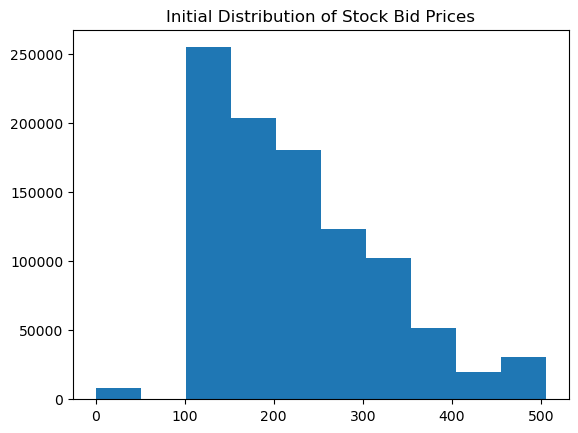

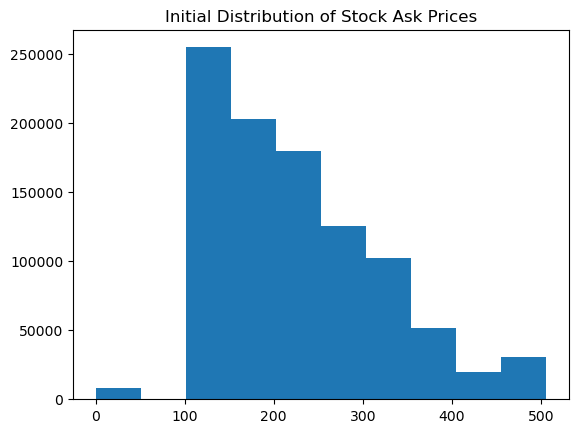

In [8]:
display(aapl_df['stock_bid'].describe())
display(aapl_df['stock_ask'].describe())
display(aapl_df['stock_mid'].describe())

plt.hist(aapl_df['stock_bid'])
plt.title('Initial Distribution of Stock Bid Prices')
plt.show()
plt.hist(aapl_df['stock_ask'])
plt.title('Initial Distribution of Stock Ask Prices')
plt.show()

I am unsure if this is an error in the data. It looks to be only about 8,490 cases, so it would be safe to drop these observations. Looking at the dates for these zero-valued prices, it looks to be over a limited 6 month period in 2018. We proceed by assuming the rest of the data is not erroneous and dropping these cases.

Obs with both zero stock bid and ask: 8490


2018-05-01      78
2018-05-10      78
2018-05-23      71
2018-06-07      77
2018-06-13     112
2018-07-24     616
2018-08-07     652
2018-08-15    1013
2018-08-22    1029
2018-09-19    1154
2018-09-25    1045
2018-10-17     985
2018-10-25     992
2018-11-01     588
Name: date_priced, dtype: int64

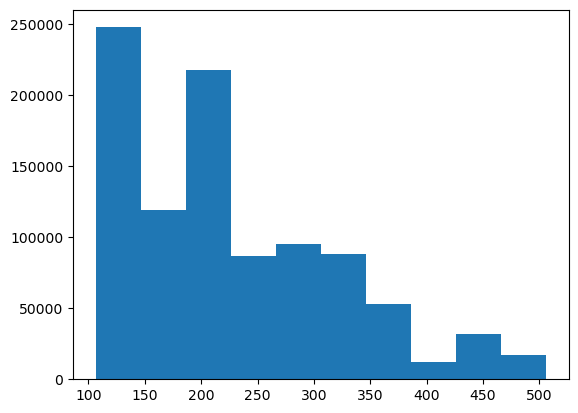

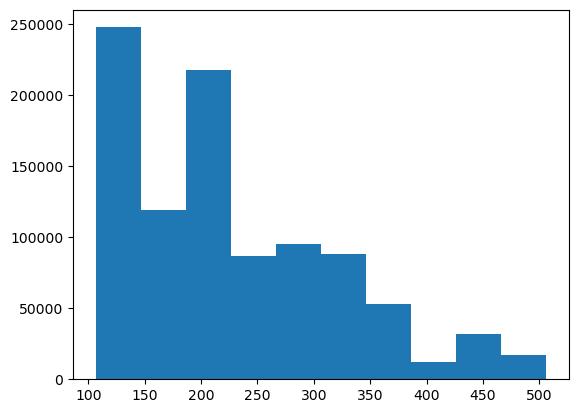

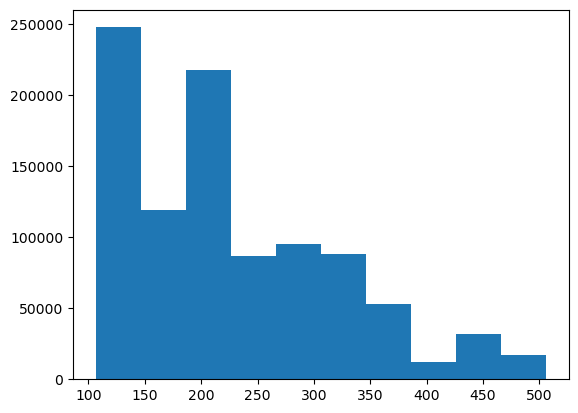

In [6]:
print(f"Obs with both zero stock bid and ask: {sum((aapl_df['stock_bid']==0) & (aapl_df['stock_ask']==0))}")

display(aapl_df[(aapl_df['stock_bid']==0) & (aapl_df['stock_ask']==0)]['date_priced'].value_counts().sort_index())

aapl_df_1 = aapl_df[(aapl_df['stock_bid'] != 0) | (aapl_df['stock_ask'] != 0)]

plt.hist(aapl_df_1['stock_bid'])
plt.title('Distribution of Stock Bid Prices After Filtering')
plt.show()

plt.hist(aapl_df_1['stock_ask'])
plt.title('Distribution of Stock Bid Prices After Filtering')
plt.show()


plt.hist(aapl_df_1['stock_mid'])
plt.show()

count    967489.000000
mean         32.049023
std          49.001829
min           0.000000
25%           0.430000
50%           9.050000
75%          45.100000
max         506.200000
Name: option_bid, dtype: float64

count    967489.000000
mean         33.095576
std          49.896395
min           0.000000
25%           0.640000
50%           9.750000
75%          46.900000
max         509.150000
Name: option_ask, dtype: float64

count    967489.000000
mean         32.572299
std          49.426447
min           0.000000
25%           0.555000
50%           9.425000
75%          46.025000
max         507.675000
Name: option_mid, dtype: float64

Obs with both zero option bid and ask: 1584


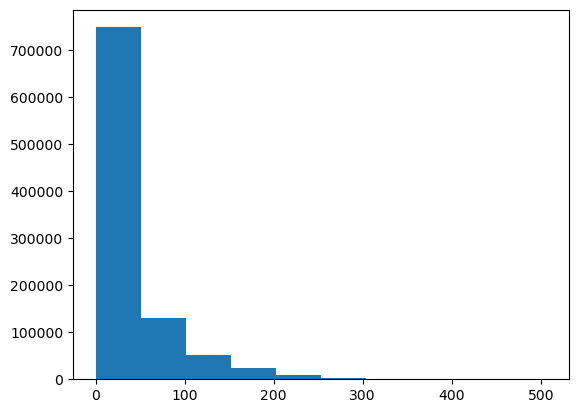

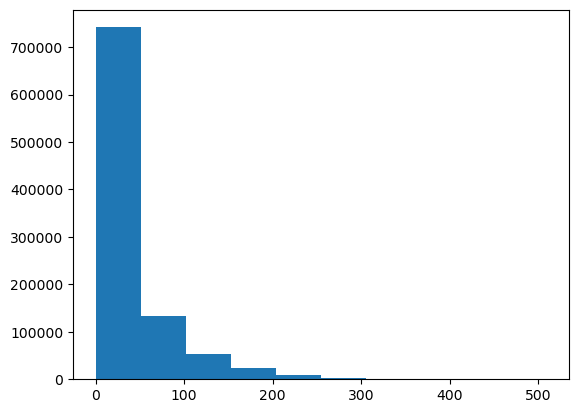

In [7]:
display(aapl_df_1['option_bid'].describe())
display(aapl_df_1['option_ask'].describe())
display(aapl_df_1['option_mid'].describe())

print(f"Obs with both zero option bid and ask: {sum((aapl_df_1['option_bid']==0) & (aapl_df_1['option_ask']==0))}")

plt.hist(aapl_df_1['option_bid'])
plt.show()
plt.hist(aapl_df_1['option_ask'])
plt.show()